In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision import models
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model class

In [3]:
class ContrastiveResNet50(nn.Module):
    def __init__(self, projectionDim = 128):
        super(ContrastiveResNet50, self).__init__()

        # Backbone
        self.backbone = models.resnet50(pretrained = True)
        self.backbone.fc = nn.Identity()  # remove ImageNet classifier

        # Projection head (SimCLR-style)
        self.projectionHead = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),

            nn.Linear(512, projectionDim)
        )

    def forward(self, x):
        features = self.backbone(x)          # [B, 2048]
        projections = self.projectionHead(features)  # [B, projectionDim]

        # Normalize for contrastive loss
        projections = nn.functional.normalize(projections, dim = 1)

        return projections


## Explanation of above code

We replaced `nn.Linear(2048, 1000)` part of the ResNet50 with the `nn.Identity()`
So, now Resnet does:

- Convolutions
- Residual blocks
- Global avearge pooling

## Output of the backbone

```python
features → shape: [B, 2048]
```

This vector represents:

“Everything the model knows visually about the image”

## Important notes

- DO NOT ADD softmax
- DO NOT ADD classifier
- This output of the model is used with **NT-XENT / InfoNCE loss**

After pretraining:

- discard `projectionHead`
- keep `backbone` for species classification


## Regression Head (Mass Predictor1)

In [5]:
class ShrimpMassRegressor(nn.Module):
    def __init__(self):
        super(ShrimpMassRegressor, self).__init__()

        self.regressionHead = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),

            nn.Linear(128, 1)   # NO activation here (linear output)
        )

    def forward(self, features):
        # features shape: [B, 2048] from backbone
        mass = self.regressionHead(features)
        return mass


## Note

###  No Activation Function Will be Used

#### Reason:

- Mass is:
     - Continuous
     - Unbounded
     - Not a probability

So, the model should be free to output any value

Activations are used to **artificially restricting the output**

### Pipeline 

Output of Resnet50 backbone will be fitted into the above class

# Dataset path

In [5]:
root_dir = Path('contrastiveDataset')
root_dir

PosixPath('contrastiveDataset')

In [6]:
from torch.utils.data import Dataset
from PIL import Image

class ContrastiveDataset(Dataset):
    def __init__(self, rootDir, transform):
        self.rootDir = rootDir
        self.transform = transform
        self.imagePaths = list(rootDir.glob('*'))

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        imgPath = self.imagePaths[idx]
        image = Image.open(imgPath).convert('RGB')

        view1 = self.transform(image)
        view2 = self.transform(image)

        return view1, view2


In [8]:
from torchvision import transforms

contrastiveTransform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=23),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Create dataset + dataloader

In [17]:
from torch.utils.data import DataLoader

dataset = ContrastiveDataset(
    rootDir = root_dir,
    transform = contrastiveTransform
)

dataloader = DataLoader(
    dataset = dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 4,
    drop_last = True
)

v1, v2 = next(iter(dataloader))
v1, v2


(tensor([[[[-1.2274, -1.2445, -1.2617,  ..., -1.1589, -1.1932, -1.2103],
           [-1.2445, -1.2445, -1.2617,  ..., -1.1075, -1.1589, -1.1760],
           [-1.2445, -1.2617, -1.2788,  ..., -1.0048, -1.0733, -1.0904],
           ...,
           [-1.3130, -1.3130, -1.3130,  ..., -1.2103, -1.2617, -1.2788],
           [-1.3130, -1.3130, -1.3130,  ..., -1.2445, -1.2959, -1.3130],
           [-1.3130, -1.3130, -1.3130,  ..., -1.2617, -1.3130, -1.3130]],
 
          [[-1.1253, -1.1429, -1.1604,  ..., -1.0553, -1.0903, -1.1078],
           [-1.1429, -1.1429, -1.1604,  ..., -1.0028, -1.0553, -1.0728],
           [-1.1429, -1.1604, -1.1779,  ..., -0.8978, -0.9678, -0.9853],
           ...,
           [-1.2129, -1.2129, -1.2129,  ..., -1.1078, -1.1604, -1.1779],
           [-1.2129, -1.2129, -1.2129,  ..., -1.1429, -1.1954, -1.2129],
           [-1.2129, -1.2129, -1.2129,  ..., -1.1604, -1.2129, -1.2129]],
 
          [[-0.8981, -0.9156, -0.9330,  ..., -0.8284, -0.8633, -0.8807],
           [-

# View the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..1.6291069].


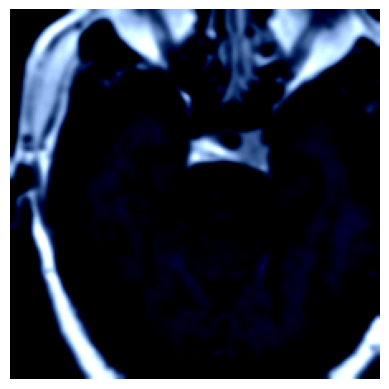

In [18]:
import matplotlib.pyplot as plt

# take first image from batch
img = v1[0]

# move to cpu if needed
img = img.cpu()

# C,H,W → H,W,C
img = img.permute(1, 2, 0)

# if normalized, undo normalization (optional)
# img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.axis("off")
plt.show()


# Define the contrastive loss (SimCLR-style)

In [19]:
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature = 0.5):
    """
    z1, z2: [B, D] normalized embeddings
    """
    B = z1.size(0)

    z = torch.cat([z1, z2], dim = 0)   # [2B, D]

    # cosine similarity
    sim = F.cosine_similarity(
        z.unsqueeze(1),
        z.unsqueeze(0),
        dim = 2
    )  # [2B, 2B]

    # remove self-similarity
    mask = torch.eye(2 * B, device = z.device).bool()
    sim = sim.masked_fill(mask, -9e15)

    # positives: i <-> i+B
    positives = torch.cat([
        torch.diag(sim, B),
        torch.diag(sim, -B)
    ], dim = 0)

    numerator = torch.exp(positives / temperature)
    denominator = torch.exp(sim / temperature).sum(dim = 1)

    loss = -torch.log(numerator / denominator)
    return loss.mean()


# Crate model + optimizer

In [21]:
model = ContrastiveResNet50(projectionDim = 128).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 3e-4,
    weight_decay = 1e-4
)


# Training loop

In [ ]:
epochs = 30   # SSL needs time

model.train()

for epoch in range(epochs):
    totalLoss = 0

    for v1, v2 in dataloader:
        v1 = v1.to(device)
        v2 = v2.to(device)

        z1 = model(v1)   # [B, 128]
        z2 = model(v2)   # [B, 128]

        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()

    avgLoss = totalLoss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avgLoss:.4f}")
